## Dependencias

In [103]:
import numpy as np
import pandas as pd

import os

from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.manifold import TSNE,MDS
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier,MLPRegressor
from sklearn.metrics import roc_auc_score,accuracy_score,mean_absolute_error,confusion_matrix
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

from functools import reduce

import matplotlib.pyplot as plt
import seaborn as sns
import cufflinks as cf
from scikitplot.metrics import plot_roc_curve

pd.set_option('display.max_columns',500)
pd.set_option('display.float_format',lambda x:'%.2f'%x)
%matplotlib inline
cf.go_offline()

## Cargar datos

In [144]:
ruta = 'datos'
archivos = [os.path.join(ruta,arch) for arch in os.listdir(ruta)]

df = pd.concat(map(lambda arch:pd.read_excel(arch),archivos),ignore_index=True)

In [145]:
df = df[['En general, ¿Cuántas estrellas darías al módulo?',
    'Por favor, emite tu libre opinión sobre el módulo en general (instructor, material, contenido, etc.)']]
df.columns = ['estrellas','opinion']

<AxesSubplot:>

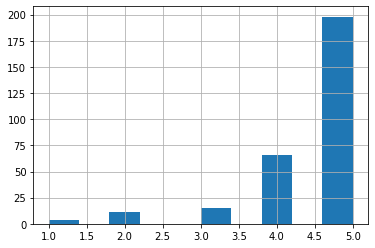

In [146]:
df.estrellas.hist()

In [147]:
df.estrellas.value_counts().sort_index()

1      4
2     11
3     15
4     66
5    198
Name: estrellas, dtype: int64

In [148]:
df.estrellas = (df.estrellas<4).astype(int)
d = {1:'Negativo',0:'Positivo'}

<AxesSubplot:>

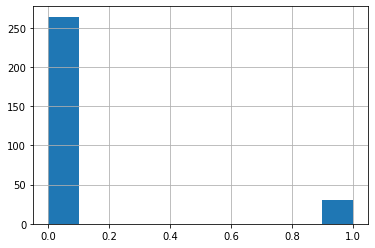

In [149]:
df.estrellas.hist()

In [150]:
df.estrellas.value_counts().sort_index()

0    264
1     30
Name: estrellas, dtype: int64

In [151]:
df.head()

,estrellas,opinion
0,0,En ocasiones el ponente va muy rápido explican...
1,0,El diplomado esta enfocado para aplicarse en e...
2,0,Creo que ayudaría bastante tener notas del cur...
3,0,pues creo que me he dado cuenta de lo mucho qu...
4,0,En mi caso el modulo se me ha hecho complicado...


## Limpieza básica

In [152]:
import re, unicodedata
def limpiar_texto(text):
    res =  unicodedata.normalize('NFD', text).encode('ascii', 'ignore')
    res = re.sub("[^a-zA-Z0-9 ]"," ", res.decode("utf-8"), flags=re.UNICODE)
    res =  u' '.join(res.lower().split())
    return res

In [153]:
df['opinion_limpia'] = df.opinion.map(limpiar_texto)

In [154]:
df.head()

,estrellas,opinion,opinion_limpia
0,0,En ocasiones el ponente va muy rápido explican...,en ocasiones el ponente va muy rapido explican...
1,0,El diplomado esta enfocado para aplicarse en e...,el diplomado esta enfocado para aplicarse en e...
2,0,Creo que ayudaría bastante tener notas del cur...,creo que ayudaria bastante tener notas del cur...
3,0,pues creo que me he dado cuenta de lo mucho qu...,pues creo que me he dado cuenta de lo mucho qu...
4,0,En mi caso el modulo se me ha hecho complicado...,en mi caso el modulo se me ha hecho complicado...


In [155]:
from nltk.corpus import stopwords

In [156]:
sw= stopwords.words('spanish')

In [157]:
df['opinion_limpia'] = df['opinion_limpia'].map(lambda x:x.split(' '))

In [158]:
df.head()

,estrellas,opinion,opinion_limpia
0,0,En ocasiones el ponente va muy rápido explican...,"[en, ocasiones, el, ponente, va, muy, rapido, ..."
1,0,El diplomado esta enfocado para aplicarse en e...,"[el, diplomado, esta, enfocado, para, aplicars..."
2,0,Creo que ayudaría bastante tener notas del cur...,"[creo, que, ayudaria, bastante, tener, notas, ..."
3,0,pues creo que me he dado cuenta de lo mucho qu...,"[pues, creo, que, me, he, dado, cuenta, de, lo..."
4,0,En mi caso el modulo se me ha hecho complicado...,"[en, mi, caso, el, modulo, se, me, ha, hecho, ..."


In [159]:
df['opinion_limpia'] = df['opinion_limpia'].map(lambda x:[w for w in x if w not in sw])

In [160]:
df.head()

,estrellas,opinion,opinion_limpia
0,0,En ocasiones el ponente va muy rápido explican...,"[ocasiones, ponente, va, rapido, explicando, t..."
1,0,El diplomado esta enfocado para aplicarse en e...,"[diplomado, enfocado, aplicarse, ambito, labor..."
2,0,Creo que ayudaría bastante tener notas del cur...,"[creo, ayudaria, bastante, tener, notas, curso..."
3,0,pues creo que me he dado cuenta de lo mucho qu...,"[pues, creo, dado, cuenta, falta, mejorar, agr..."
4,0,En mi caso el modulo se me ha hecho complicado...,"[caso, modulo, hecho, complicado, bien, asi, m..."


In [161]:
df['opinion_limpia'] = df['opinion_limpia'].map(lambda x:" ".join(x))

In [162]:
df.head()

,estrellas,opinion,opinion_limpia
0,0,En ocasiones el ponente va muy rápido explican...,ocasiones ponente va rapido explicando temas t...
1,0,El diplomado esta enfocado para aplicarse en e...,diplomado enfocado aplicarse ambito laboral bu...
2,0,Creo que ayudaría bastante tener notas del cur...,creo ayudaria bastante tener notas curso clase...
3,0,pues creo que me he dado cuenta de lo mucho qu...,pues creo dado cuenta falta mejorar agradable ...
4,0,En mi caso el modulo se me ha hecho complicado...,caso modulo hecho complicado bien asi mismo pu...


In [163]:
vocab = reduce(lambda x,y:x+y,[x.split(' ')for x in df['opinion_limpia'].values.tolist()])

In [164]:
vocab = set(vocab)

In [165]:
len(vocab)

1710

## Representación vectorial

In [208]:
cv = TfidfVectorizer(ngram_range=(1,3),max_features=200)

In [209]:
cv.fit(df['opinion_limpia'])

TfidfVectorizer(max_features=200, ngram_range=(1, 3))

In [210]:
X = pd.DataFrame(cv.transform(df['opinion_limpia']).toarray(),columns=cv.get_feature_names())

In [211]:
X

,ademas,alta,alto,alumno,alumnos,ambito,aplicacion,aplicar,apoyo,aprender,aprendi,aprendido,aprendizaje,asi,aunque,ayuda,bastante,bien,bien temas,buen,buen contenido,buen curso,buen modulo,buena,bueno,buenos,cada,calidad,carga,carla,caso,claro,clase,clases,codigo,codigos,completo,conceptos,conocimiento,conocimientos,considero,contenido,contenidos,cosas,creo,cualquier,curso,da,dar,datos,debe,deberia,demas,demasiado,detalle,dia,dificil,dificultad,diplomado,domina,dominio,duda,dudas,ejemplo,ejemplos,embargo,ensenar,entender,entrega,entregar,equipo,especificos,esperaba,evaluar,examen,examenes,excelente,excelente modulo,excelente profesor,experiencia,explica,explicacion,falta,falto,final,forma,general,gracias,gran,grupo,gusta,gustado,gustaria,gustavo,gusto,habia,habria,hace,hacer,hacia,hecho,hizo,igual,importante,informacion,instructor,instructora,interesante,interesantes,llevar,lorena,manera,mas,mas ejemplos,mas tiempo,material,materiales,mayor,mejor,mejorar,menos,mismo,modelos,modulo,modulo completo,modulos,momento,mucha,muchas,necesario,nivel,nota,oportunidad,oscar,parece,parecio,parte,particular,persona,poder,podria,podrian,ponente,practica,practicas,practicas examenes,preguntas,presentaciones,primer,primer modulo,problema,profesor,profesora,profesores,profundidad,programacion,proyecto,puede,pues,punto,python,rapido,referencias,requisitos,resolver,resolver dudas,respecto,resultados,sabe,ser,seria,si,sido,siempre,siento,solo,tal,tal vez,tambien,tan,tecnico,tema,temas,tener,tenia,teorico,tiempo,tiempo practicas,tiempos,todas,tomar,trabajo,ultimo,unico,veces,ver,verdad,vez,vista,visto
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.17,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.15,0.00,0.00,0.00,0.00,0.00,0.00,0.18,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.69,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.22,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.22,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.20,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.17,0.20,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.21,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.17,0.00,0.00,0.20,0.00,0.00,0.00,0.23,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.17,0.00,0.00,0.19,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.68,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.41,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.41,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.46,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.43,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.37,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.38,0.00,0.36,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0

In [212]:
df.estrellas.value_counts()

0    264
1     30
Name: estrellas, dtype: int64

In [214]:
pipe = make_pipeline(StandardScaler(),MDS(n_components=3))
Xt = pd.DataFrame(pipe.fit_transform(X),columns=['d1','d2','d3'])

Xt['sentimiento'] = df['estrellas'].replace(d)

Xt.iplot(kind="scatter3d",
         x='d1', 
         y='d2', 
         z='d3', 
         mode="markers",
         categories='sentimiento',
         size=3)

## Entrenar clasificador

In [215]:
y = df['estrellas'].copy()
sc = MinMaxScaler()
Xs = pd.DataFrame(sc.fit_transform(X),columns=X.columns)
Xt,Xv,yt,yv = train_test_split(Xs,y,train_size=0.7)

In [216]:
hyp = dict(hidden_layer_sizes = [(a,b,c, ) for a in range(1,20)  for b in range(1,20)  for c in range(1,20)],
activation = ['identity', 'logistic', 'tanh', 'relu'],
solver = ['lbfgs', 'sgd', 'adam'],
alpha = np.arange(0.0001,0.001,0.0001),
learning_rate = ['constant', 'invscaling', 'adaptive'],
learning_rate_init = np.arange(0.001,0.01,0.001))

In [217]:
grid = RandomizedSearchCV(cv=3,
                   n_iter=2000,
                   n_jobs=-1,
                   param_distributions=hyp,
                   scoring='roc_auc',
                   verbose=True,
                   estimator=MLPClassifier())

In [218]:
grid.fit(Xt,yt)

Fitting 3 folds for each of 2000 candidates, totalling 6000 fits


RandomizedSearchCV(cv=3, estimator=MLPClassifier(), n_iter=2000, n_jobs=-1,
                   param_distributions={'activation': ['identity', 'logistic',
                                                       'tanh', 'relu'],
                                        'alpha': array([0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008,
       0.0009]),
                                        'hidden_layer_sizes': [(1, 1, 1),
                                                               (1, 1, 2),
                                                               (1, 1, 3),
                                                               (1, 1, 4),
                                                               (1, 1, 5),
                                                               (1, 1, 6),
                                                               (1, 1, 7),
                                                               (1, 1, 8),
                                            

In [219]:
grid.best_score_

0.8423085962747517

In [220]:
grid.best_params_

{'solver': 'lbfgs',
 'learning_rate_init': 0.009000000000000001,
 'learning_rate': 'invscaling',
 'hidden_layer_sizes': (5, 11, 6),
 'alpha': 0.0009000000000000001,
 'activation': 'relu'}

In [221]:
red = grid.best_estimator_
type(red)

sklearn.neural_network._multilayer_perceptron.MLPClassifier

In [222]:
red.fit(Xt,yt)

MLPClassifier(alpha=0.0009000000000000001, hidden_layer_sizes=(5, 11, 6),
              learning_rate='invscaling',
              learning_rate_init=0.009000000000000001, solver='lbfgs')

/home/jose/entornos/ins/lib/python3.8/site-packages/sklearn/utils/deprecation.py:86: FutureWarning:

Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.

/home/jose/entornos/ins/lib/python3.8/site-packages/sklearn/utils/deprecation.py:86: FutureWarning:

Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.



<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

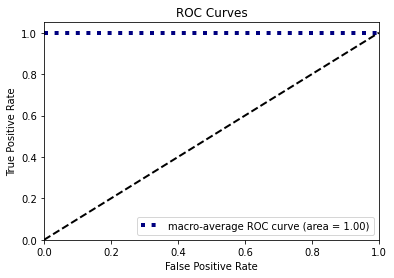

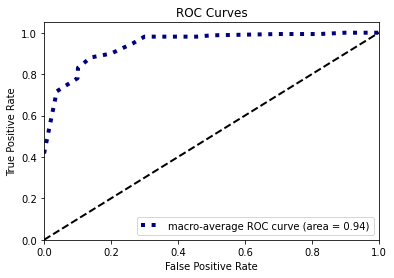

In [223]:
plot_roc_curve(curves='macro',y_true=yt,y_probas=red.predict_proba(Xt))
plot_roc_curve(curves='macro',y_true=yv,y_probas=red.predict_proba(Xv))

In [226]:
print(accuracy_score(y_true=yt,y_pred=red.predict(Xt)))
print(accuracy_score(y_true=yv,y_pred=red.predict(Xv)))

1.0
0.9101123595505618


In [227]:
print(confusion_matrix(y_true=yt,y_pred=red.predict(Xt)),"\n"*3)
print(confusion_matrix(y_true=yv,y_pred=red.predict(Xv)))

[[185   0]
 [  0  20]] 



[[78  1]
 [ 7  3]]


## Explicabilidad del modelo

In [230]:
df['palabras'] = df.opinion_limpia.map(lambda x:x.split(' '))

In [238]:
def negatividad(palabra):
    return palabra,df.loc[df['palabras'].map(lambda x:palabra in x)].estrellas.mean()

In [242]:
exp = pd.DataFrame(map(negatividad,vocab),columns=['palabra','negatividad'])


<AxesSubplot:>

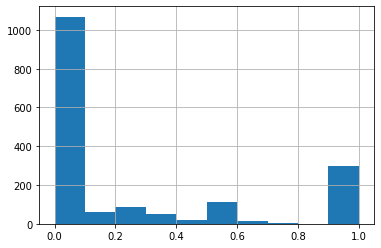

In [243]:
exp.negatividad.hist()

<AxesSubplot:xlabel='palabra'>

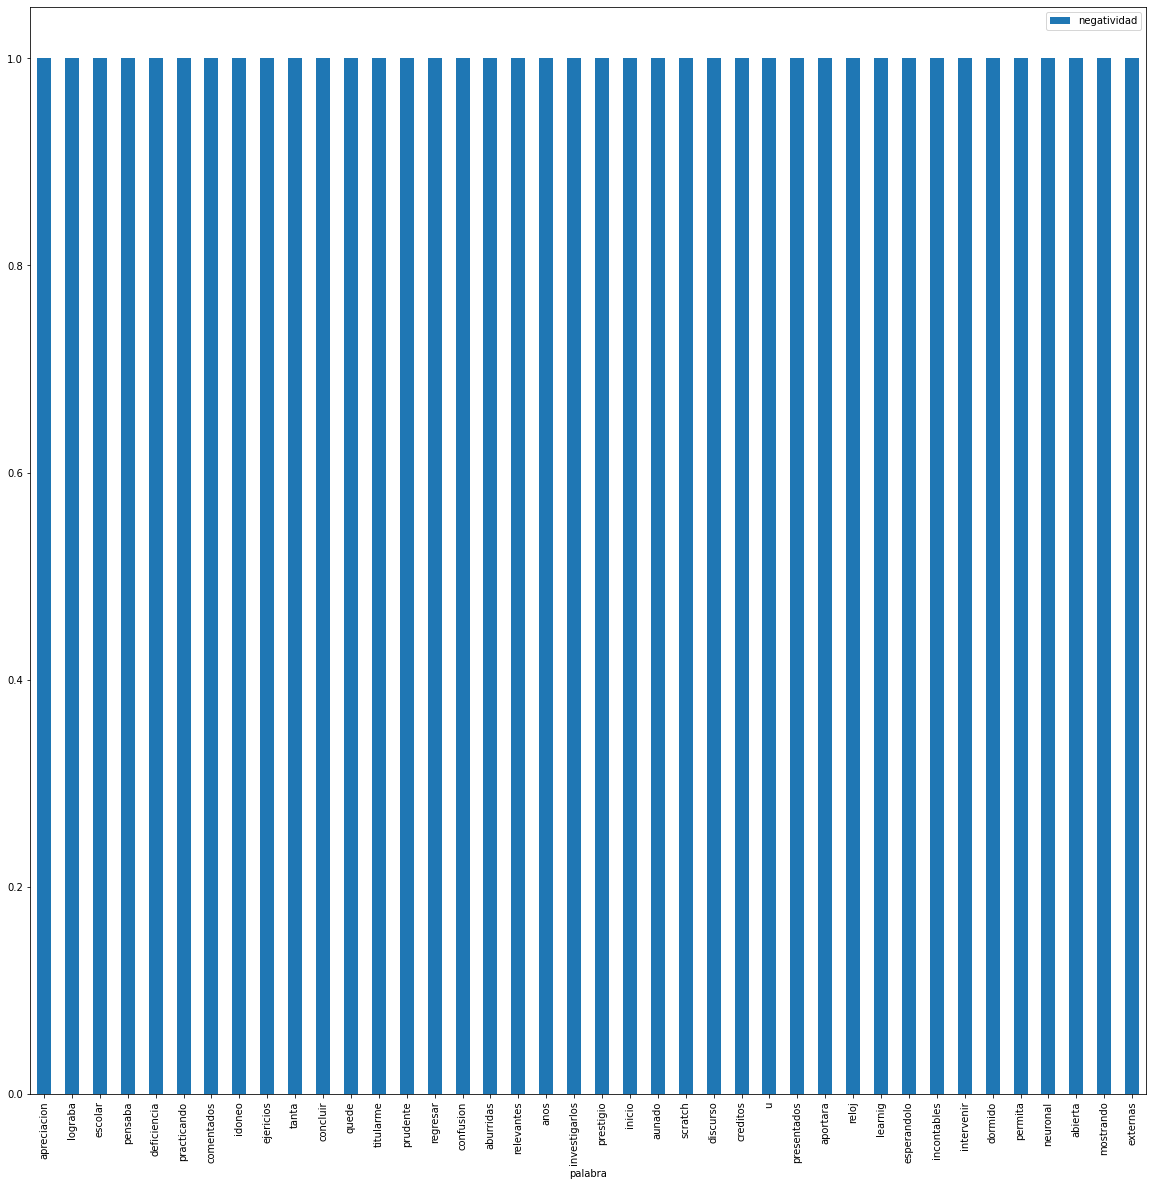

In [249]:
exp.sort_values(by='negatividad',ascending=False).head(40).set_index('palabra').plot(kind='bar',figsize=(20,20))